# Iniciar Sessão Spark

import os
## Set up environment variables
os.environ['JAVA_HOME'] = r'C:\Program Files\Java\jdk-21'
os.environ['SPARK_HOME'] = r'C:\Users\kawda\Downloads\spark-3.5.4-bin-hadoop3\spark-3.5.4-bin-hadoop3'

## Initialize a Spark session
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder \
	.master("local[*]") \
	.config("spark.executor.memory", "8g") \
	.config("spark.driver.memory", "8g") \
	.getOrCreate()

## Verify the Spark session
spark()

# Imports

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from collections import Counter
from boruta import BorutaPy
from scipy import stats

# Dados

In [89]:
# Abrir os dados disponíveis sobre o doenças cardíacas
df_HDP = pd.read_csv(r'C:\Users\kawda\OneDrive\Desktop\Data_Science\Semana_6\Tarefa\Predicao_Doencas_Cardiacas\Heart_Disease_Prediction.xls')
df_HDP.head()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,Absence
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,Absence


# Data Preparation

## Retirar espaços dos nomes das variáveis e substituir por underscore

In [90]:
# Substituir espaços por underscores nos nomes das colunas
df_HDP.columns = df_HDP.columns.str.replace(' ', '_')

# Verificar as primeiras linhas para confirmar a substituição
df_HDP.head()

,Age,Sex,Chest_pain_type,BP,Cholesterol,FBS_over_120,EKG_results,Max_HR,Exercise_angina,ST_depression,Slope_of_ST,Number_of_vessels_fluro,Thallium,Heart_Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,Absence
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,Absence


## Tratamento inicial padrão (Alta porcentagem de nulos, Variáveis constantes, Missings)

In [91]:
def get_metadata(dataframe):
	# Coleta de metadados básicos
	metadata = pd.DataFrame({
		'nome_variavel': dataframe.columns,
		'tipo': dataframe.dtypes,
		'qt_nulos': dataframe.isnull().sum(),
		'percent_nulos': round((dataframe.isnull().sum() / len(dataframe)) * 100, 2),
		'cardinalidade': dataframe.nunique(),
	})

	# Função para testar normalidade usando o teste de Shapiro-Wilk
	def test_normality(series, alpha=0.05):
		if series.dtype in ["float64", "int64", "int32"]:
			statistic, p_value = stats.shapiro(series.dropna())  # dropping NA values for the test
			return p_value > alpha
		else:
			return None  # Return None for non-numeric data types

	# Aplicando teste de normalidade
	metadata["fl_normal"] = dataframe.apply(test_normality)

	metadata = metadata.sort_values(by='percent_nulos', ascending=False)
	metadata = metadata.reset_index(drop=True)

	return metadata

# Apply the function to the dataframe
metadados = get_metadata(df_HDP)
metadados.head()

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade,fl_normal
0,Age,int64,0,0.0,41,False
1,Sex,int64,0,0.0,2,False
2,Chest_pain_type,int64,0,0.0,4,False
3,BP,int64,0,0.0,47,False
4,Cholesterol,int64,0,0.0,144,False


In [92]:
def preprocess_dataframe(df):
	# Drop columns with >80% missing values
	total_count = len(df)
	columns_to_drop = [col for col in df.columns if df[col].isnull().sum() / total_count > 0.8]
	df = df.drop(columns=columns_to_drop)
	
	# Replace missing values
	for col_name in df.columns:
		data_type = df[col_name].dtype
		
		if np.issubdtype(data_type, np.number):
			mean_value = df[col_name].mean()
			df[col_name] = df[col_name].fillna(mean_value)
		elif data_type == object:
			df[col_name] = df[col_name].fillna("Desconhecido")
	
	# Drop columns with variance equals to 0
	numeric_columns = df.select_dtypes(include=[np.number]).columns
	variances = df[numeric_columns].var()
	columns_to_drop = variances[variances == 0].index.tolist()
	df = df.drop(columns=columns_to_drop)
	
	return df

# Apply the function to the dataframe
abt_full = preprocess_dataframe(df_HDP)
abt_full.head()

,Age,Sex,Chest_pain_type,BP,Cholesterol,FBS_over_120,EKG_results,Max_HR,Exercise_angina,ST_depression,Slope_of_ST,Number_of_vessels_fluro,Thallium,Heart_Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,Absence
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,Absence


# Identificar e separar o target e fazer o test-split

In [93]:
# Verificar os dados e separar o target
lista_spec = ['Heart_Disease']
abt_wt_target = df_HDP.drop(columns=lista_spec)

# Split the data into train and test sets
abt_00, abt_test = train_test_split(abt_wt_target, test_size=0.2, random_state=88)

abt_00.head()

,Age,Sex,Chest_pain_type,BP,Cholesterol,FBS_over_120,EKG_results,Max_HR,Exercise_angina,ST_depression,Slope_of_ST,Number_of_vessels_fluro,Thallium
95,47,1,4,110,275,0,2,118,1,1.0,2,1,3
39,48,1,4,122,222,0,2,186,0,0.0,1,0,3
185,43,1,3,130,315,0,0,162,0,1.9,1,1,3
111,41,1,2,110,235,0,0,153,0,0.0,1,0,3
53,63,0,2,140,195,0,0,179,0,0.0,1,2,3


# Processamentos das variáveis

## Tratamento de variáveis numéricas (Padronização)

In [94]:
def normalize_dataframe(df):
	# Instanciando o scaler
	scaler = StandardScaler()

	# Selecionando colunas numéricas
	numeric_cols = df.select_dtypes(include=['float64', 'int64', 'int32']).columns

	# Aplicando a normalização
	df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

	return df

# Apply the function to the dataframe
abt_00 = normalize_dataframe(abt_00)

# Show the result
abt_00.head()

,Age,Sex,Chest_pain_type,BP,Cholesterol,FBS_over_120,EKG_results,Max_HR,Exercise_angina,ST_depression,Slope_of_ST,Number_of_vessels_fluro,Thallium
95,-0.854029,0.685119,0.854792,-1.203489,0.503796,-0.42465,1.023444,-1.306652,1.399609,-0.038861,0.653877,0.367369,-0.872062
39,-0.743236,0.685119,0.854792,-0.527114,-0.533330,-0.42465,1.023444,1.564698,-0.714485,-0.913224,-0.969541,-0.690654,-0.872062
185,-1.297201,0.685119,-0.206329,-0.076197,1.286532,-0.42465,-0.986228,0.551280,-0.714485,0.748067,-0.969541,0.367369,-0.872062
111,-1.518787,0.685119,-1.267450,-1.203489,-0.278940,-0.42465,-0.986228,0.171249,-0.714485,-0.913224,-0.969541,-0.690654,-0.872062
53,0.918658,-1.459601,-1.267450,0.487450,-1.061676,-0.42465,-0.986228,1.269118,-0.714485,-0.913224,-0.969541,1.425392,-0.872062


## Tratamento de variáveis categóricas

### Baixa Cardinalidade (Dummy)

In [95]:
def apply_onehot_encoding(df, metadata, card_cutoff=5):
	# Filtrar variáveis categóricas de baixa cardinalidade
	df_categ_onehot = metadata[(metadata['cardinalidade'] <= card_cutoff) & (metadata['tipo'] == 'object')]
	lista_onehot = list(df_categ_onehot.nome_variavel.values)
	print('Lista de vars para OneHot Encoding: ', lista_onehot)

	# Instanciar o encoder
	encoder = OneHotEncoder(drop='first', sparse_output=False)

	# Aplicar o one-hot encoding
	encoded_data = encoder.fit_transform(df[lista_onehot])

	# Criar um DataFrame com as colunas codificadas, mantendo o índice original
	encoded_cols = encoder.get_feature_names_out(lista_onehot)
	encoded_df = pd.DataFrame(encoded_data, columns=encoded_cols, index=df.index)

	# Concatenar o DataFrame codificado com o DataFrame original
	df = pd.concat([df.drop(lista_onehot, axis=1), encoded_df], axis=1)

	return df

### Alta Cardinalidade (Label Encoding)

In [96]:
def apply_label_encoding(df, metadata, card_cutoff=5):
	# Filtrar variáveis categóricas de alta cardinalidade
	df_categ_labelenc = metadata[(metadata['cardinalidade'] > card_cutoff) & (metadata['tipo'] == 'object')]
	lista_lenc = list(df_categ_labelenc.nome_variavel.values)
	print('Lista de vars para Label Encoding: ', lista_lenc)

	# Aplicando LabelEncoder nas colunas desejadas
	for col in lista_lenc:
		encoder = LabelEncoder()
		df[col] = encoder.fit_transform(df[col])

	return df

### Juntar os dados sensíveis

In [97]:
# Inner join usando o índice
abt_model = pd.merge(abt_00, df_HDP[lista_spec], left_index=True, right_index=True, how='inner')
abt_model.head()

,Age,Sex,Chest_pain_type,BP,Cholesterol,FBS_over_120,EKG_results,Max_HR,Exercise_angina,ST_depression,Slope_of_ST,Number_of_vessels_fluro,Thallium,Heart_Disease
95,-0.854029,0.685119,0.854792,-1.203489,0.503796,-0.42465,1.023444,-1.306652,1.399609,-0.038861,0.653877,0.367369,-0.872062,Presence
39,-0.743236,0.685119,0.854792,-0.527114,-0.533330,-0.42465,1.023444,1.564698,-0.714485,-0.913224,-0.969541,-0.690654,-0.872062,Absence
185,-1.297201,0.685119,-0.206329,-0.076197,1.286532,-0.42465,-0.986228,0.551280,-0.714485,0.748067,-0.969541,0.367369,-0.872062,Absence
111,-1.518787,0.685119,-1.267450,-1.203489,-0.278940,-0.42465,-0.986228,0.171249,-0.714485,-0.913224,-0.969541,-0.690654,-0.872062,Absence
53,0.918658,-1.459601,-1.267450,0.487450,-1.061676,-0.42465,-0.986228,1.269118,-0.714485,-0.913224,-0.969541,1.425392,-0.872062,Absence


In [98]:
# Transformar os valores da coluna Heart_Disease
abt_model['Heart_Disease'] = abt_model['Heart_Disease'].replace({'Presence': 1, 'Absence': 0})

# Verificar as primeiras linhas para confirmar a transformação
abt_model.head()

C:\Users\kawda\AppData\Local\Temp\ipykernel_7620\2126059326.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  abt_model['Heart_Disease'] = abt_model['Heart_Disease'].replace({'Presence': 1, 'Absence': 0})


,Age,Sex,Chest_pain_type,BP,Cholesterol,FBS_over_120,EKG_results,Max_HR,Exercise_angina,ST_depression,Slope_of_ST,Number_of_vessels_fluro,Thallium,Heart_Disease
95,-0.854029,0.685119,0.854792,-1.203489,0.503796,-0.42465,1.023444,-1.306652,1.399609,-0.038861,0.653877,0.367369,-0.872062,1
39,-0.743236,0.685119,0.854792,-0.527114,-0.533330,-0.42465,1.023444,1.564698,-0.714485,-0.913224,-0.969541,-0.690654,-0.872062,0
185,-1.297201,0.685119,-0.206329,-0.076197,1.286532,-0.42465,-0.986228,0.551280,-0.714485,0.748067,-0.969541,0.367369,-0.872062,0
111,-1.518787,0.685119,-1.267450,-1.203489,-0.278940,-0.42465,-0.986228,0.171249,-0.714485,-0.913224,-0.969541,-0.690654,-0.872062,0
53,0.918658,-1.459601,-1.267450,0.487450,-1.061676,-0.42465,-0.986228,1.269118,-0.714485,-0.913224,-0.969541,1.425392,-0.872062,0


# Métodos de seleção de variáveis

## Feature Importance

In [99]:
# Cópia para FI
abt_fi = abt_model.copy()
abt_fi.head()

,Age,Sex,Chest_pain_type,BP,Cholesterol,FBS_over_120,EKG_results,Max_HR,Exercise_angina,ST_depression,Slope_of_ST,Number_of_vessels_fluro,Thallium,Heart_Disease
95,-0.854029,0.685119,0.854792,-1.203489,0.503796,-0.42465,1.023444,-1.306652,1.399609,-0.038861,0.653877,0.367369,-0.872062,1
39,-0.743236,0.685119,0.854792,-0.527114,-0.533330,-0.42465,1.023444,1.564698,-0.714485,-0.913224,-0.969541,-0.690654,-0.872062,0
185,-1.297201,0.685119,-0.206329,-0.076197,1.286532,-0.42465,-0.986228,0.551280,-0.714485,0.748067,-0.969541,0.367369,-0.872062,0
111,-1.518787,0.685119,-1.267450,-1.203489,-0.278940,-0.42465,-0.986228,0.171249,-0.714485,-0.913224,-0.969541,-0.690654,-0.872062,0
53,0.918658,-1.459601,-1.267450,0.487450,-1.061676,-0.42465,-0.986228,1.269118,-0.714485,-0.913224,-0.969541,1.425392,-0.872062,0


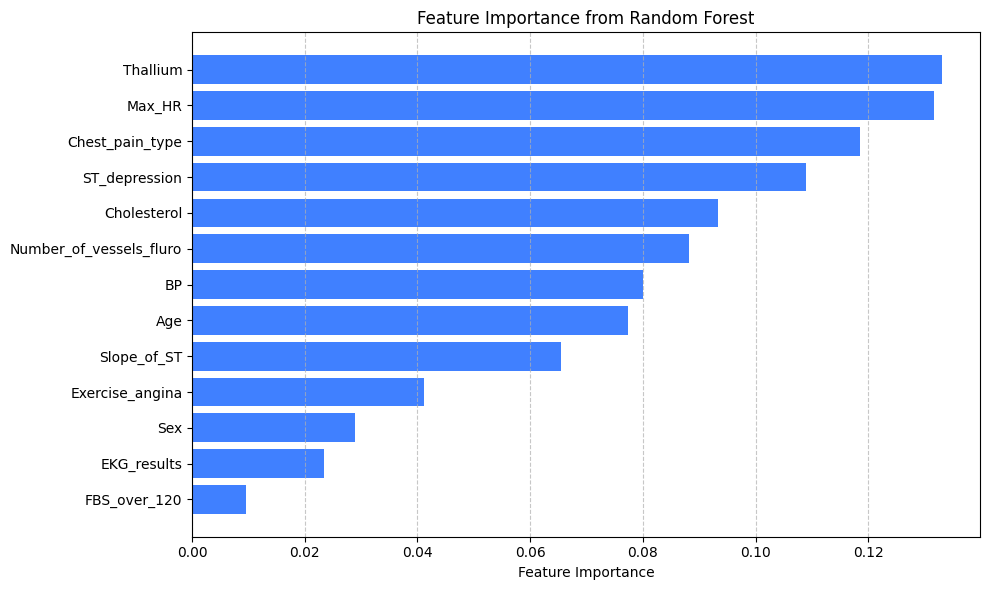

In [100]:
X = abt_fi.drop(axis=1, columns='Heart_Disease')
y = abt_fi.Heart_Disease

# Treinar modelo com algoritmo Random Forest (Calma, não precisa focar no modelo neste momento)
clf = RandomForestClassifier() # troque aqui qual classificador quer utilizar: GradientBoostingClassifier, DecisionTreeClassifier
clf.fit(X, y)

# Obter importância das variáveis
feature_importances = clf.feature_importances_
features = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

#' Ordenar variáveis por importância
features = features.sort_values(by='Importance', ascending=False)

# Estabelecer um limite de corte, por exemplo, x% da importância máxima
cutoff_maximp = 0.6

cutoff = cutoff_maximp * feature_importances.max()

# Selecionar variáveis acima do corte
selected_features = X.columns[feature_importances > cutoff].tolist()
selected_features
# Visualizando a importância das variáveis em barras horizontais

plt.figure(figsize=(10, 6))
sorted_idx = feature_importances.argsort()

plt.barh(X.columns[sorted_idx], feature_importances[sorted_idx], color=(0.25, 0.5, 1))  # tom de azul claro
plt.xlabel("Feature Importance")
plt.title("Feature Importance from Random Forest")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [101]:
# Mantendo somente as variáveis selecionadas na ABT
abt_01 = abt_fi[selected_features + ['Heart_Disease']]

abt_01.head()

,Chest_pain_type,BP,Cholesterol,Max_HR,ST_depression,Number_of_vessels_fluro,Thallium,Heart_Disease
95,0.854792,-1.203489,0.503796,-1.306652,-0.038861,0.367369,-0.872062,1
39,0.854792,-0.527114,-0.533330,1.564698,-0.913224,-0.690654,-0.872062,0
185,-0.206329,-0.076197,1.286532,0.551280,0.748067,0.367369,-0.872062,0
111,-1.267450,-1.203489,-0.278940,0.171249,-0.913224,-0.690654,-0.872062,0
53,-1.267450,0.487450,-1.061676,1.269118,-0.913224,1.425392,-0.872062,0


## Recursive Feature Elimination (RFE)

In [102]:
# Cópia para RFE
abt_rfe = abt_model.copy()
abt_rfe.head()

,Age,Sex,Chest_pain_type,BP,Cholesterol,FBS_over_120,EKG_results,Max_HR,Exercise_angina,ST_depression,Slope_of_ST,Number_of_vessels_fluro,Thallium,Heart_Disease
95,-0.854029,0.685119,0.854792,-1.203489,0.503796,-0.42465,1.023444,-1.306652,1.399609,-0.038861,0.653877,0.367369,-0.872062,1
39,-0.743236,0.685119,0.854792,-0.527114,-0.533330,-0.42465,1.023444,1.564698,-0.714485,-0.913224,-0.969541,-0.690654,-0.872062,0
185,-1.297201,0.685119,-0.206329,-0.076197,1.286532,-0.42465,-0.986228,0.551280,-0.714485,0.748067,-0.969541,0.367369,-0.872062,0
111,-1.518787,0.685119,-1.267450,-1.203489,-0.278940,-0.42465,-0.986228,0.171249,-0.714485,-0.913224,-0.969541,-0.690654,-0.872062,0
53,0.918658,-1.459601,-1.267450,0.487450,-1.061676,-0.42465,-0.986228,1.269118,-0.714485,-0.913224,-0.969541,1.425392,-0.872062,0


In [103]:
# Separar as variáveis independentes (X) e a variável dependente (y)
X_rfe = abt_rfe.drop(columns=['Heart_Disease'])
y_rfe = abt_rfe['Heart_Disease']

# Instanciar o modelo de regressão logística com mais iterações
model = LogisticRegression(max_iter=2000)

# Instanciar o RFE com o modelo e o número desejado de features
rfe = RFE(estimator=model, n_features_to_select=5)

# Ajustar o RFE aos dados
rfe = rfe.fit(X_rfe, y_rfe)

# Obter as variáveis selecionadas
selected_features_rfe = X_rfe.columns[rfe.support_].tolist()
print('Selected features by RFE:', selected_features_rfe)

# Criar um novo dataframe com as variáveis selecionadas
abt_rfe_selected = abt_rfe[selected_features_rfe + ['Heart_Disease']]
abt_rfe_selected.head()

Selected features by RFE: ['Chest_pain_type', 'EKG_results', 'ST_depression', 'Number_of_vessels_fluro', 'Thallium']


,Chest_pain_type,EKG_results,ST_depression,Number_of_vessels_fluro,Thallium,Heart_Disease
95,0.854792,1.023444,-0.038861,0.367369,-0.872062,1
39,0.854792,1.023444,-0.913224,-0.690654,-0.872062,0
185,-0.206329,-0.986228,0.748067,0.367369,-0.872062,0
111,-1.267450,-0.986228,-0.913224,-0.690654,-0.872062,0
53,-1.267450,-0.986228,-0.913224,1.425392,-0.872062,0


## Boruta

In [104]:
# Cópia para Boruta
abt_boruta = abt_model.copy()

In [105]:
# Separar as variáveis independentes (X) e a variável dependente (y)
X_boruta = abt_boruta.drop(columns=['Heart_Disease'])
y_boruta = abt_boruta['Heart_Disease']

# Instanciar o modelo de Random Forest
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

# Instanciar o Boruta
boruta = BorutaPy(estimator=rf, n_estimators='auto', verbose=2, random_state=1)

# Ajustar o Boruta aos dados
boruta.fit(X_boruta.values, y_boruta.values)

# Obter as variáveis selecionadas
selected_features_boruta = X_boruta.columns[boruta.support_].tolist()
print('Selected features by Boruta:', selected_features_boruta)

# Criar um novo dataframe com as variáveis selecionadas
abt_boruta_selected = abt_boruta[selected_features_boruta + ['Heart_Disease']]
abt_boruta_selected.head()

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	7
Tentative: 	3
Rejected: 	3
Iteration: 	9 / 100
Confirmed: 	7
Tentative: 	3
Rejected: 	3
Iteration: 	10 / 100
Confirmed: 	7
Tentative: 	3
Rejected: 	3
Iteration: 	11 / 100
Confirmed: 	7
Tentative: 	3
Rejected: 	3
Iteration: 	12 / 100
Confirmed: 	8
Tentative: 	2
Rejected: 	3
Iteration: 	13 / 100
Confirmed: 	8
Tentative: 	2
Rejected: 	3
Iteration: 	14 / 100
Confirmed: 	8
Tentative: 	2
Rejected: 	3
Iteration: 	15 / 100
Confirmed: 	8
Tentative: 	2
Rejected: 	3
Iteration: 	16 / 100
Confirmed: 	8
Tentative: 	2
Rejected: 	3
Iteration:

,Age,Chest_pain_type,Cholesterol,Max_HR,ST_depression,Slope_of_ST,Number_of_vessels_fluro,Thallium,Heart_Disease
95,-0.854029,0.854792,0.503796,-1.306652,-0.038861,0.653877,0.367369,-0.872062,1
39,-0.743236,0.854792,-0.533330,1.564698,-0.913224,-0.969541,-0.690654,-0.872062,0
185,-1.297201,-0.206329,1.286532,0.551280,0.748067,-0.969541,0.367369,-0.872062,0
111,-1.518787,-1.267450,-0.278940,0.171249,-0.913224,-0.969541,-0.690654,-0.872062,0
53,0.918658,-1.267450,-1.061676,1.269118,-0.913224,-0.969541,1.425392,-0.872062,0


## Pearson Correlation

In [106]:
# Cópia para Pearson
abt_pearson = abt_model.copy()

In [108]:
# Calcular a correlação de Pearson entre as features e a variável alvo
correlation_matrix = abt_pearson.corr()

# Selecionar as features que possuem uma correlação significativa com a variável alvo
correlation_threshold = 0.1  # Defina um limiar de correlação
significant_features = correlation_matrix.index[abs(correlation_matrix["Heart_Disease"]) > correlation_threshold].tolist()

# Remover a variável alvo da lista de features significativas
significant_features.remove("Heart_Disease")

# Criar um novo dataframe com as features selecionadas
abt_pearson_selected = abt_pearson[significant_features + ["Heart_Disease"]]

print("Selected feature by Pearson:", significant_features)

# Exibir as primeiras linhas do novo dataframe
abt_pearson_selected.head()

Selected feature by Pearson: ['Age', 'Sex', 'Chest_pain_type', 'BP', 'Cholesterol', 'EKG_results', 'Max_HR', 'Exercise_angina', 'ST_depression', 'Slope_of_ST', 'Number_of_vessels_fluro', 'Thallium']


,Age,Sex,Chest_pain_type,BP,Cholesterol,EKG_results,Max_HR,Exercise_angina,ST_depression,Slope_of_ST,Number_of_vessels_fluro,Thallium,Heart_Disease
95,-0.854029,0.685119,0.854792,-1.203489,0.503796,1.023444,-1.306652,1.399609,-0.038861,0.653877,0.367369,-0.872062,1
39,-0.743236,0.685119,0.854792,-0.527114,-0.533330,1.023444,1.564698,-0.714485,-0.913224,-0.969541,-0.690654,-0.872062,0
185,-1.297201,0.685119,-0.206329,-0.076197,1.286532,-0.986228,0.551280,-0.714485,0.748067,-0.969541,0.367369,-0.872062,0
111,-1.518787,0.685119,-1.267450,-1.203489,-0.278940,-0.986228,0.171249,-0.714485,-0.913224,-0.969541,-0.690654,-0.872062,0
53,0.918658,-1.459601,-1.267450,0.487450,-1.061676,-0.986228,1.269118,-0.714485,-0.913224,-0.969541,1.425392,-0.872062,0


## Corte por IV

In [109]:
# Cópia para IV
abt_iv = abt_model.copy()

In [111]:
def calculate_iv(df, feature, target, bins=10):
	"""
	Função para calcular o Information Value (IV) de uma variável.
	"""
	df = df[[feature, target]].copy()
	df['bin'] = pd.qcut(df[feature], bins, duplicates='drop')
	grouped = df.groupby('bin', observed=False)[target].agg(['count', 'sum'])
	grouped['non_event'] = grouped['count'] - grouped['sum']
	grouped['event_rate'] = grouped['sum'] / grouped['sum'].sum()
	grouped['non_event_rate'] = grouped['non_event'] / grouped['non_event'].sum()
	grouped['woe'] = np.log(grouped['event_rate'] / grouped['non_event_rate'])
	grouped['iv'] = (grouped['event_rate'] - grouped['non_event_rate']) * grouped['woe']
	iv = grouped['iv'].sum()
	return iv

# Calcular o IV para cada variável
iv_values = {}
target = 'Heart_Disease'
for feature in abt_iv.columns:
	if feature != target:
		iv = calculate_iv(abt_iv, feature, target)
		iv_values[feature] = iv

# Definir um limiar de corte para o IV
iv_threshold = 0.1

# Selecionar as variáveis cujo IV é maior que o limiar definido
selected_features_iv = [feature for feature, iv in iv_values.items() if iv > iv_threshold]
print('Selected features by IV:', selected_features_iv)

# Criar um novo dataframe com as variáveis selecionadas
abt_iv_selected = abt_iv[selected_features_iv + [target]]
abt_iv_selected.head()

Selected features by IV: ['Age', 'Chest_pain_type', 'BP', 'Cholesterol', 'Max_HR', 'ST_depression', 'Number_of_vessels_fluro', 'Thallium']


,Age,Chest_pain_type,BP,Cholesterol,Max_HR,ST_depression,Number_of_vessels_fluro,Thallium,Heart_Disease
95,-0.854029,0.854792,-1.203489,0.503796,-1.306652,-0.038861,0.367369,-0.872062,1
39,-0.743236,0.854792,-0.527114,-0.533330,1.564698,-0.913224,-0.690654,-0.872062,0
185,-1.297201,-0.206329,-0.076197,1.286532,0.551280,0.748067,0.367369,-0.872062,0
111,-1.518787,-1.267450,-1.203489,-0.278940,0.171249,-0.913224,-0.690654,-0.872062,0
53,0.918658,-1.267450,0.487450,-1.061676,1.269118,-0.913224,1.425392,-0.872062,0


## PCA + IV

In [112]:
# Cópia para PCA+IV
abt_pca_iv = abt_model.copy()

In [113]:
# Calcular o IV para cada variável
iv_values_pca = {}
target = 'Heart_Disease'
for feature in abt_pca_iv.columns:
	if feature != target:
		iv = calculate_iv(abt_pca_iv, feature, target)
		iv_values_pca[feature] = iv

# Definir um limiar de corte para o IV
iv_threshold_pca = 0.1

# Selecionar as variáveis cujo IV é maior que o limiar definido
selected_features_iv_pca = [feature for feature, iv in iv_values_pca.items() if iv > iv_threshold_pca]
print('Selected features by IV:', selected_features_iv_pca)

# Criar um novo dataframe com as variáveis selecionadas
abt_iv_pca_selected = abt_pca_iv[selected_features_iv_pca]

# Separar as variáveis independentes (X) e a variável dependente (y)
X_iv_pca = abt_iv_pca_selected
y_iv_pca = abt_pca_iv[target]

# Aplicar PCA
pca = PCA(n_components=5)  # Defina o número de componentes principais desejado
X_pca = pca.fit_transform(X_iv_pca)

# Criar um novo dataframe com as componentes principais
pca_columns = [f'PC{i+1}' for i in range(X_pca.shape[1])]
abt_pca_iv_selected = pd.DataFrame(X_pca, columns=pca_columns)
abt_pca_iv_selected[target] = y_iv_pca.values

# Exibir as primeiras linhas do novo dataframe
abt_pca_iv_selected.head()

Selected features by IV: ['Age', 'Chest_pain_type', 'BP', 'Cholesterol', 'Max_HR', 'ST_depression', 'Number_of_vessels_fluro', 'Thallium']


,PC1,PC2,PC3,PC4,PC5,Heart_Disease
0,-0.299784,-0.855910,-1.515941,0.304147,-1.062791,1
1,1.870094,-0.611853,-0.565769,0.595920,-0.035801,0
2,0.495709,0.291989,-0.027347,1.141016,-0.131157,0
3,2.300125,-0.523454,-0.508879,-0.286693,-0.187576,0
4,0.844066,1.284349,-0.369105,-1.578317,1.792729,0


# Comparação das técnicas

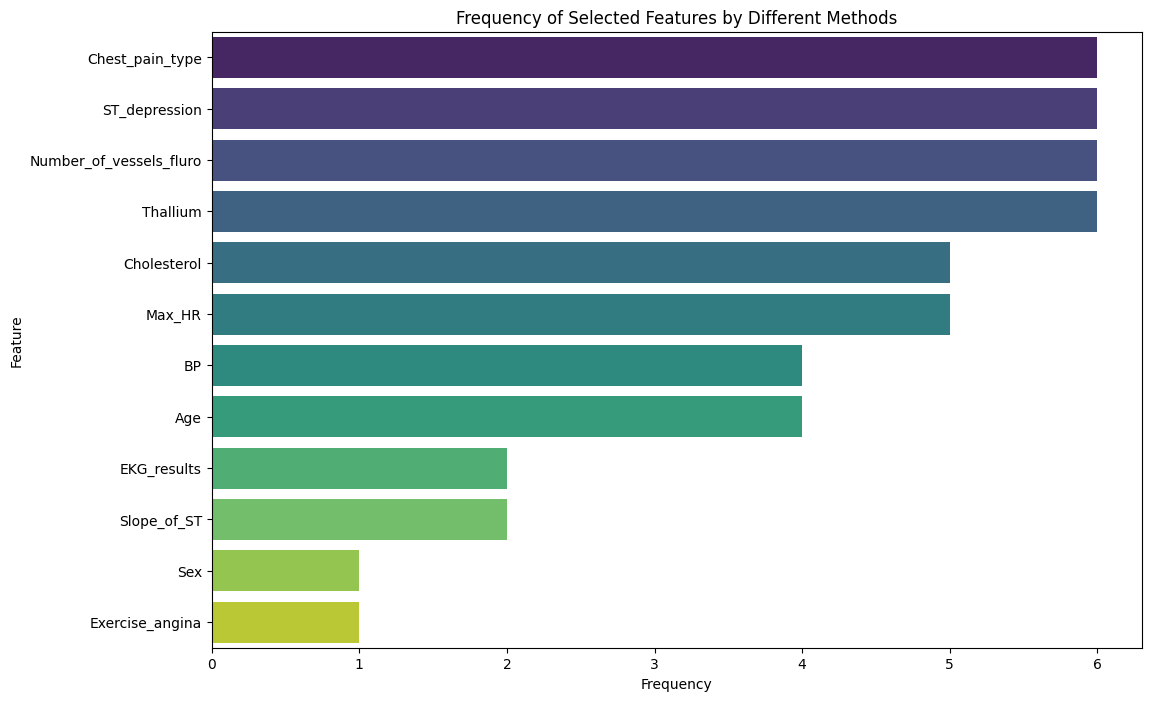

Feature Importance: 5
Boruta: 5
IV: 5
Pearson: 5
PCA + IV: 5
RFE: 4


In [114]:
# Variáveis selecionadas por cada método
selected_features_dict = {
	'Feature Importance': selected_features,
	'RFE': selected_features_rfe,
	'Boruta': selected_features_boruta,
	'IV': selected_features_iv,
	'Pearson': significant_features,
	'PCA + IV': selected_features_iv_pca
}

# Contar a frequência de cada variável
all_selected_features = [feature for features in selected_features_dict.values() for feature in features]
feature_counts = Counter(all_selected_features)

# Criar um DataFrame para facilitar a visualização
feature_counts_df = pd.DataFrame.from_dict(feature_counts, orient='index', columns=['Frequency']).reset_index()
feature_counts_df.columns = ['Feature', 'Frequency']

# Plotar o histograma de frequência
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_counts_df.sort_values(by='Frequency', ascending=False), x='Frequency', y='Feature', hue='Feature', palette='viridis', legend=False)
plt.title('Frequency of Selected Features by Different Methods')
plt.xlabel('Frequency')
plt.ylabel('Feature')
plt.show()

# Listar as técnicas em ordem de qual selecionou o maior número do top 5 de variáveis mais selecionadas
top_5_features = feature_counts_df.sort_values(by='Frequency', ascending=False).head(5)['Feature'].tolist()
technique_counts = {technique: len(set(features) & set(top_5_features)) for technique, features in selected_features_dict.items()}
sorted_techniques = sorted(technique_counts.items(), key=lambda item: item[1], reverse=True)

# Exibir a lista em ordem
for technique, count in sorted_techniques:
	print(f"{technique}: {count}")


Temos aqui uma comparação de quais variáveis foram escolhidas e quantas vezes por cada técnica, assim temos uma "opnião diferente" para quais variáveis são realmente relevantes para o comportamento do Target, nesse caso a sobrevivência dos tripulantes. Além disso, abaixo do gráfico há quais técnicas de feature selection selecionaram o top-5 das variáveis escolhidas, indicando boas técnicas para serem utilizadas.